# Урок 2. Feed-forward neural network
# Домашнее задание

1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch import optim

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print(image.size())
print(label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
torch.Size([3, 32, 32])
6


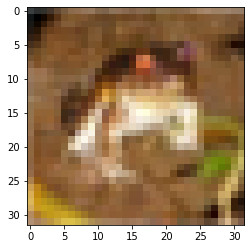

In [3]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [5]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Составим класс для сети, с возможностью регулирования количества слоев и нейронов в них:

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=3):
        super().__init__()
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, (2 ** (n_layers - 2)) * hidden_dim))
        for i in range(1, n_layers - 1):
          self.layers.append(nn.Linear((2 ** (n_layers - i - 1)) * hidden_dim, (2 ** (n_layers - i - 2)) * hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers[:-1]:
          x = layer(x)
          x = F.leaky_relu(x)
        x = self.layers[-1](x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x)
        return x

Составим функция для обучения сети. Будем сразу валидироваться на тесте.

**Примечание по рассчету кросс-энтропии:**
Как я поняла, встроенная функция расчитыват усредненный лосс на батче. Поэтому надо в конце эпохи делить аккумулятивный лосс на количество батчей, а не на количество картинок.

In [8]:
def learn_net(net, criterion, optimizer, num_epochs):
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0
      running_loss_test = 0.0
      running_items_test = 0.0
      running_right = 0.0
      running_right_test = 0.0

      net.train()
      for i, data in enumerate(train_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Обнуляем градиент
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)
          running_right += (labels == torch.max(outputs, 1)[1]).sum()

      running_right = running_right.item() 
      print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / i:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
      acc = running_right / running_items
      train_acc.append(acc)
      # print(type(acc), acc, train_acc)
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

      net.eval()
      for i, data in enumerate(test_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)

          running_loss_test += loss.item()
          running_items_test += len(labels)
          running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

      running_right_test = running_right_test.item()
      print(f'Loss_test: {running_loss_test / i:.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
      test_acc.append(running_right_test / running_items_test)
      running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

  print('Training is finished!')

  return train_acc, test_acc

In [11]:
from tensorflow.python.client import device_lib

In [33]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4834700456469847964
xla_global_id: -1
]


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Обучим несколько сетей с глубиной 3, но с разным количеством нейронов (меняем параметр hidden_dim)

In [14]:
train_metrics = []
test_metrics = []
for i in np.arange(50, 201, 50):
  net = Net(3*32*32, i, 10)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.104. Acc: 0.239. Loss_test: 1.964. Acc_test: 0.288
Epoch [2/30]. Loss_train: 1.905. Acc: 0.323. Loss_test: 1.919. Acc_test: 0.313
Epoch [3/30]. Loss_train: 1.827. Acc: 0.352. Loss_test: 1.884. Acc_test: 0.336
Epoch [4/30]. Loss_train: 1.775. Acc: 0.370. Loss_test: 1.774. Acc_test: 0.367
Epoch [5/30]. Loss_train: 1.727. Acc: 0.386. Loss_test: 1.717. Acc_test: 0.382
Epoch [6/30]. Loss_train: 1.685. Acc: 0.401. Loss_test: 1.687. Acc_test: 0.402
Epoch [7/30]. Loss_train: 1.649. Acc: 0.415. Loss_test: 1.647. Acc_test: 0.416
Epoch [8/30]. Loss_train: 1.620. Acc: 0.426. Loss_test: 1.696. Acc_test: 0.390
Epoch [9/30]. Loss_train: 1.594. Acc: 0.434. Loss_test: 1.739. Acc_test: 0.380
Epoch [10/30]. Loss_train: 1.569. Acc: 0.443. Loss_test: 1.659. Acc_test: 0.411
Epoch [11/30]. Loss_train: 1.548. Acc: 0.452. Loss_test: 1.582. Acc_test: 0.432
Epoch [12/30]. Loss_train: 1.529. Acc: 0.457. Loss_test: 1.568. Acc_test: 0.442
Epoch [13/30]. Loss_train: 1.508. Acc: 0.463. Los

Epoch [13/30]. Loss_train: 1.484. Acc: 0.476. Loss_test: 1.568. Acc_test: 0.443
Epoch [14/30]. Loss_train: 1.467. Acc: 0.482. Loss_test: 1.550. Acc_test: 0.449
Epoch [15/30]. Loss_train: 1.445. Acc: 0.490. Loss_test: 1.497. Acc_test: 0.470
Epoch [16/30]. Loss_train: 1.428. Acc: 0.495. Loss_test: 1.489. Acc_test: 0.466
Epoch [17/30]. Loss_train: 1.410. Acc: 0.503. Loss_test: 1.546. Acc_test: 0.460
Epoch [18/30]. Loss_train: 1.398. Acc: 0.507. Loss_test: 1.478. Acc_test: 0.471
Epoch [19/30]. Loss_train: 1.382. Acc: 0.512. Loss_test: 1.569. Acc_test: 0.434
Epoch [20/30]. Loss_train: 1.366. Acc: 0.516. Loss_test: 1.555. Acc_test: 0.453
Epoch [21/30]. Loss_train: 1.351. Acc: 0.521. Loss_test: 1.608. Acc_test: 0.437
Epoch [22/30]. Loss_train: 1.337. Acc: 0.527. Loss_test: 1.552. Acc_test: 0.449
Epoch [23/30]. Loss_train: 1.325. Acc: 0.532. Loss_test: 1.458. Acc_test: 0.482
Epoch [24/30]. Loss_train: 1.311. Acc: 0.536. Loss_test: 1.440. Acc_test: 0.486
Epoch [25/30]. Loss_train: 1.299. Acc: 0

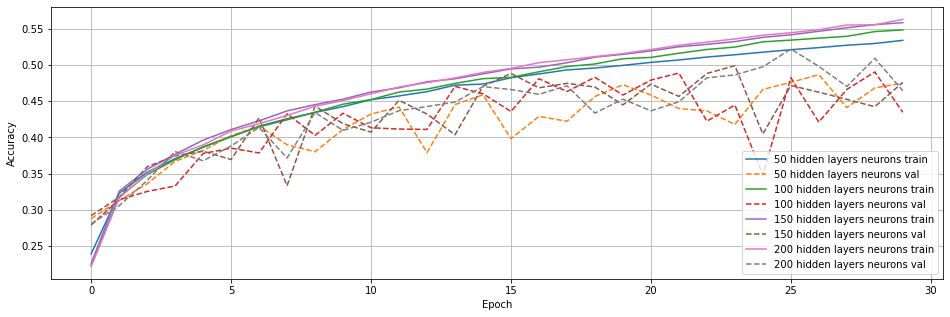

In [15]:
plt.figure(figsize = (16,5))
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{(i + 1) * 50} hidden layers neurons' +' train')
    plt.plot(test_metrics[i],'--',label = f'{(i + 1) * 50} hidden layers neurons' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

Как видно, и на трейне и на тесте лучше всего проявляет себя модель с 200 нейронами на предпоследнем слое.

Далее будем менять количество слоев, но так, чтобы количество нейронов в первом слое оставалось неизменным. Поэтому, соответственно, параметр hidden_dim зависит от количества слоев.

In [16]:
train_metrics = []
test_metrics = []
for i in np.arange(3, 7, 1):
  hidden_dim = int(200 * (0.5 ** (i - 3)))
  net = Net(3*32*32, hidden_dim, 10, n_layers=i)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.112. Acc: 0.242. Loss_test: 1.957. Acc_test: 0.279
Epoch [2/30]. Loss_train: 1.898. Acc: 0.326. Loss_test: 1.849. Acc_test: 0.342
Epoch [3/30]. Loss_train: 1.818. Acc: 0.356. Loss_test: 1.773. Acc_test: 0.374
Epoch [4/30]. Loss_train: 1.757. Acc: 0.376. Loss_test: 1.791. Acc_test: 0.355
Epoch [5/30]. Loss_train: 1.707. Acc: 0.395. Loss_test: 1.724. Acc_test: 0.389
Epoch [6/30]. Loss_train: 1.667. Acc: 0.409. Loss_test: 1.660. Acc_test: 0.407
Epoch [7/30]. Loss_train: 1.629. Acc: 0.425. Loss_test: 1.620. Acc_test: 0.419
Epoch [8/30]. Loss_train: 1.598. Acc: 0.436. Loss_test: 1.616. Acc_test: 0.425
Epoch [9/30]. Loss_train: 1.570. Acc: 0.445. Loss_test: 1.637. Acc_test: 0.413
Epoch [10/30]. Loss_train: 1.545. Acc: 0.455. Loss_test: 1.537. Acc_test: 0.456
Epoch [11/30]. Loss_train: 1.521. Acc: 0.465. Loss_test: 1.579. Acc_test: 0.434
Epoch [12/30]. Loss_train: 1.498. Acc: 0.471. Loss_test: 1.542. Acc_test: 0.449
Epoch [13/30]. Loss_train: 1.480. Acc: 0.480. Los

Epoch [13/30]. Loss_train: 1.780. Acc: 0.344. Loss_test: 1.748. Acc_test: 0.359
Epoch [14/30]. Loss_train: 1.740. Acc: 0.362. Loss_test: 1.812. Acc_test: 0.311
Epoch [15/30]. Loss_train: 1.698. Acc: 0.378. Loss_test: 1.708. Acc_test: 0.382
Epoch [16/30]. Loss_train: 1.664. Acc: 0.393. Loss_test: 1.782. Acc_test: 0.351
Epoch [17/30]. Loss_train: 1.641. Acc: 0.402. Loss_test: 1.806. Acc_test: 0.347
Epoch [18/30]. Loss_train: 1.610. Acc: 0.409. Loss_test: 1.593. Acc_test: 0.411
Epoch [19/30]. Loss_train: 1.586. Acc: 0.421. Loss_test: 1.801. Acc_test: 0.344
Epoch [20/30]. Loss_train: 1.560. Acc: 0.431. Loss_test: 1.928. Acc_test: 0.322
Epoch [21/30]. Loss_train: 1.535. Acc: 0.440. Loss_test: 1.548. Acc_test: 0.441
Epoch [22/30]. Loss_train: 1.514. Acc: 0.449. Loss_test: 1.685. Acc_test: 0.397
Epoch [23/30]. Loss_train: 1.493. Acc: 0.456. Loss_test: 1.871. Acc_test: 0.350
Epoch [24/30]. Loss_train: 1.470. Acc: 0.466. Loss_test: 1.778. Acc_test: 0.393
Epoch [25/30]. Loss_train: 1.454. Acc: 0

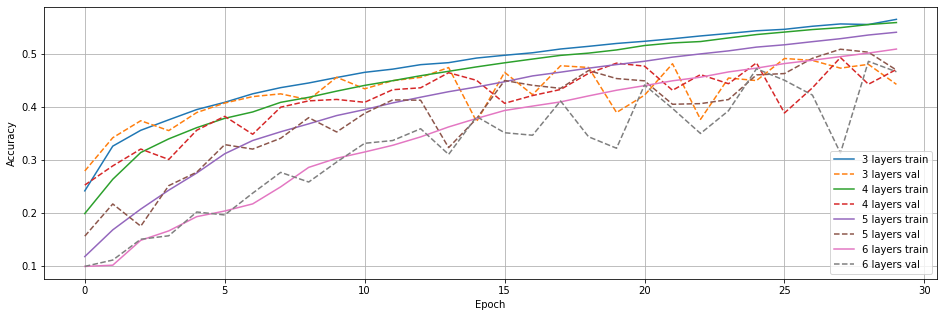

In [17]:
plt.figure(figsize = (16,5))
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{(i + 3)} layers' +' train')
    plt.plot(test_metrics[i],'--',label = f'{(i + 3)} layers' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

Лучше всего проявляет себя модель с 3-мя слоями. Единственное, что на последних двух эпохах модель резко переобучилась и метрика на тесте улетела вниз.

Далее попробуем применить различные оптимизаторы:

In [18]:
train_metrics = []
test_metrics = []

for i in range(4):
  net = Net(3*32*32, 200, 10, n_layers=3)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  if i == 0:
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  elif i == 1:
    optimizer = optim.Adagrad(net.parameters(), lr=0.1)
  elif i == 2:
    optimizer = optim.RMSprop(net.parameters(), lr=0.1, alpha=0.99)
  else:
    optimizer = optim.Adam(net.parameters(), lr=0.1)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.118. Acc: 0.244. Loss_test: 1.962. Acc_test: 0.301
Epoch [2/30]. Loss_train: 1.902. Acc: 0.324. Loss_test: 1.909. Acc_test: 0.315
Epoch [3/30]. Loss_train: 1.821. Acc: 0.355. Loss_test: 1.807. Acc_test: 0.359
Epoch [4/30]. Loss_train: 1.758. Acc: 0.376. Loss_test: 1.766. Acc_test: 0.373
Epoch [5/30]. Loss_train: 1.710. Acc: 0.394. Loss_test: 1.721. Acc_test: 0.383
Epoch [6/30]. Loss_train: 1.664. Acc: 0.410. Loss_test: 1.753. Acc_test: 0.385
Epoch [7/30]. Loss_train: 1.630. Acc: 0.423. Loss_test: 1.650. Acc_test: 0.414
Epoch [8/30]. Loss_train: 1.597. Acc: 0.435. Loss_test: 1.650. Acc_test: 0.419
Epoch [9/30]. Loss_train: 1.568. Acc: 0.447. Loss_test: 1.647. Acc_test: 0.403
Epoch [10/30]. Loss_train: 1.540. Acc: 0.454. Loss_test: 1.607. Acc_test: 0.429
Epoch [11/30]. Loss_train: 1.518. Acc: 0.464. Loss_test: 1.524. Acc_test: 0.455
Epoch [12/30]. Loss_train: 1.494. Acc: 0.473. Loss_test: 1.578. Acc_test: 0.425
Epoch [13/30]. Loss_train: 1.477. Acc: 0.477. Los

Epoch [10/30]. Loss_train: 82.868. Acc: 0.224. Loss_test: 61.648. Acc_test: 0.241
Epoch [11/30]. Loss_train: 76.335. Acc: 0.219. Loss_test: 63.861. Acc_test: 0.170
Epoch [12/30]. Loss_train: 4743.292. Acc: 0.136. Loss_test: 949.277. Acc_test: 0.181
Epoch [13/30]. Loss_train: 529.826. Acc: 0.181. Loss_test: 217.856. Acc_test: 0.219
Epoch [14/30]. Loss_train: 211.848. Acc: 0.206. Loss_test: 279.068. Acc_test: 0.204
Epoch [15/30]. Loss_train: 239.680. Acc: 0.204. Loss_test: 305.556. Acc_test: 0.172
Epoch [16/30]. Loss_train: 700.109. Acc: 0.173. Loss_test: 490.695. Acc_test: 0.166
Epoch [17/30]. Loss_train: 474.511. Acc: 0.184. Loss_test: 132.369. Acc_test: 0.233
Epoch [18/30]. Loss_train: 169.403. Acc: 0.217. Loss_test: 146.951. Acc_test: 0.200
Epoch [19/30]. Loss_train: 101.783. Acc: 0.233. Loss_test: 135.270. Acc_test: 0.217
Epoch [20/30]. Loss_train: 1539.056. Acc: 0.175. Loss_test: 13909.646. Acc_test: 0.100
Epoch [21/30]. Loss_train: 2316.431. Acc: 0.149. Loss_test: 489.615. Acc_tes

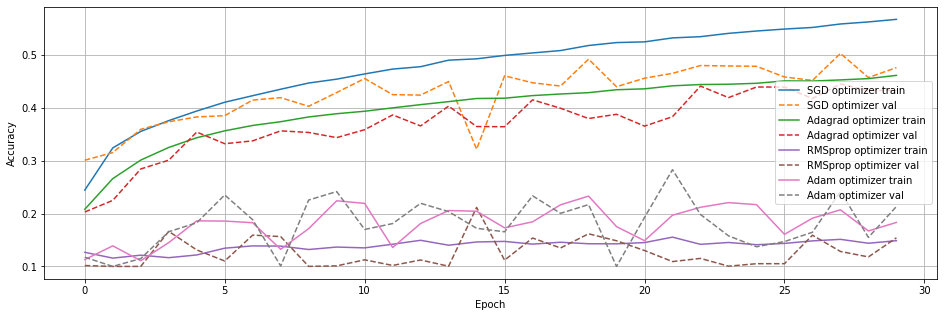

In [19]:
plt.figure(figsize = (16,5))
optimizers_func = ['SGD', 'Adagrad', 'RMSprop', 'Adam']
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{optimizers_func[i]} optimizer' +' train')
    plt.plot(test_metrics[i],'--',label = f'{optimizers_func[i]} optimizer' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

Очень странно, но Adam совершенно ужасные результаты показывает, как и RMSprop. Лучше всего себя показала SGD

Теперь посмотрим, как меняется процесс обучения при разных размерах батчей:

In [20]:
train_metrics = []
test_metrics = []
for i in np.arange(4):
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=int(64 * 2 ** i), 
                                            shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=int(8 * 2 ** i),
                                            shuffle=False)
  net = Net(3*32*32, 200, 10, n_layers=3)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.116. Acc: 0.246. Loss_test: 1.967. Acc_test: 0.298
Epoch [2/30]. Loss_train: 1.900. Acc: 0.323. Loss_test: 1.859. Acc_test: 0.333
Epoch [3/30]. Loss_train: 1.818. Acc: 0.353. Loss_test: 1.785. Acc_test: 0.365
Epoch [4/30]. Loss_train: 1.759. Acc: 0.376. Loss_test: 1.909. Acc_test: 0.322
Epoch [5/30]. Loss_train: 1.710. Acc: 0.392. Loss_test: 1.735. Acc_test: 0.377
Epoch [6/30]. Loss_train: 1.669. Acc: 0.407. Loss_test: 1.666. Acc_test: 0.410
Epoch [7/30]. Loss_train: 1.633. Acc: 0.422. Loss_test: 1.677. Acc_test: 0.398
Epoch [8/30]. Loss_train: 1.601. Acc: 0.434. Loss_test: 1.701. Acc_test: 0.392
Epoch [9/30]. Loss_train: 1.573. Acc: 0.443. Loss_test: 1.564. Acc_test: 0.443
Epoch [10/30]. Loss_train: 1.546. Acc: 0.454. Loss_test: 1.557. Acc_test: 0.448
Epoch [11/30]. Loss_train: 1.521. Acc: 0.461. Loss_test: 1.779. Acc_test: 0.369
Epoch [12/30]. Loss_train: 1.501. Acc: 0.469. Loss_test: 1.541. Acc_test: 0.451
Epoch [13/30]. Loss_train: 1.483. Acc: 0.475. Los

Epoch [13/30]. Loss_train: 1.898. Acc: 0.338. Loss_test: 1.887. Acc_test: 0.336
Epoch [14/30]. Loss_train: 1.887. Acc: 0.341. Loss_test: 1.875. Acc_test: 0.341
Epoch [15/30]. Loss_train: 1.875. Acc: 0.346. Loss_test: 1.864. Acc_test: 0.345
Epoch [16/30]. Loss_train: 1.864. Acc: 0.350. Loss_test: 1.852. Acc_test: 0.349
Epoch [17/30]. Loss_train: 1.854. Acc: 0.353. Loss_test: 1.841. Acc_test: 0.353
Epoch [18/30]. Loss_train: 1.843. Acc: 0.358. Loss_test: 1.831. Acc_test: 0.360
Epoch [19/30]. Loss_train: 1.833. Acc: 0.360. Loss_test: 1.820. Acc_test: 0.366
Epoch [20/30]. Loss_train: 1.823. Acc: 0.365. Loss_test: 1.813. Acc_test: 0.364
Epoch [21/30]. Loss_train: 1.814. Acc: 0.368. Loss_test: 1.801. Acc_test: 0.369
Epoch [22/30]. Loss_train: 1.804. Acc: 0.370. Loss_test: 1.796. Acc_test: 0.370
Epoch [23/30]. Loss_train: 1.795. Acc: 0.374. Loss_test: 1.783. Acc_test: 0.370
Epoch [24/30]. Loss_train: 1.787. Acc: 0.376. Loss_test: 1.775. Acc_test: 0.375
Epoch [25/30]. Loss_train: 1.778. Acc: 0

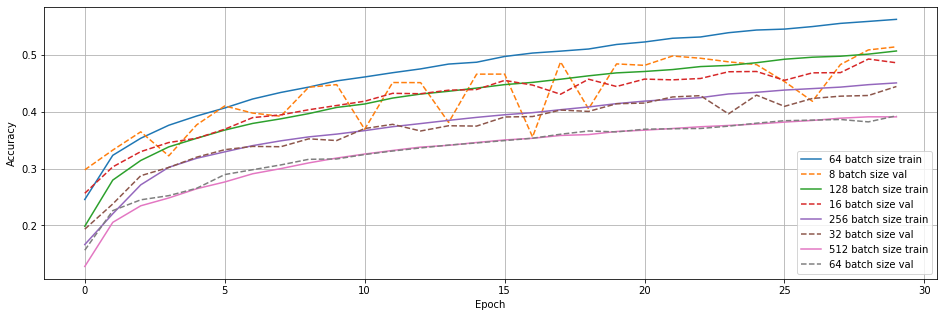

In [21]:
plt.figure(figsize = (16,5))
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{64 * 2 ** i} batch size' +' train')
    plt.plot(test_metrics[i],'--',label = f'{8 * 2 ** i} batch size' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

По графику можно сделать следующие выводы:


*   Чем меньше батчи, тем нестабильнее ведет себя валидация на тесте
*   Обучение на батчах в 512 картинок выглядит очень стабильным, и кажется, что у такого обучения есть перспектива, но надо в разы больше эпох (около 90).
*   Для обучения на 30 эпохах лучшим вариантов выглядит батч в 128 картинов.





In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=128, 
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                          shuffle=False)
net = Net(3*32*32, 200, 10, n_layers=3)
net.to(device)
net.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
train_acc, test_acc = learn_net(net, criterion, optimizer, 30)


Epoch [1/30]. Loss_train: 2.223. Acc: 0.213. Loss_test: 2.107. Acc_test: 0.253
Epoch [2/30]. Loss_train: 2.026. Acc: 0.284. Loss_test: 1.962. Acc_test: 0.297
Epoch [3/30]. Loss_train: 1.930. Acc: 0.314. Loss_test: 1.898. Acc_test: 0.332
Epoch [4/30]. Loss_train: 1.880. Acc: 0.335. Loss_test: 1.860. Acc_test: 0.335
Epoch [5/30]. Loss_train: 1.840. Acc: 0.352. Loss_test: 1.820. Acc_test: 0.356
Epoch [6/30]. Loss_train: 1.806. Acc: 0.363. Loss_test: 1.789. Acc_test: 0.371
Epoch [7/30]. Loss_train: 1.775. Acc: 0.374. Loss_test: 1.754. Acc_test: 0.384
Epoch [8/30]. Loss_train: 1.746. Acc: 0.384. Loss_test: 1.741. Acc_test: 0.387
Epoch [9/30]. Loss_train: 1.721. Acc: 0.391. Loss_test: 1.726. Acc_test: 0.385
Epoch [10/30]. Loss_train: 1.697. Acc: 0.400. Loss_test: 1.706. Acc_test: 0.399
Epoch [11/30]. Loss_train: 1.675. Acc: 0.407. Loss_test: 1.666. Acc_test: 0.409
Epoch [12/30]. Loss_train: 1.654. Acc: 0.416. Loss_test: 1.644. Acc_test: 0.420
Epoch [13/30]. Loss_train: 1.634. Acc: 0.423. Los

In [38]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

GroundTruth:  cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship
Predicted:  cat truck ship plane deer frog cat frog dog car ship truck frog horse car ship


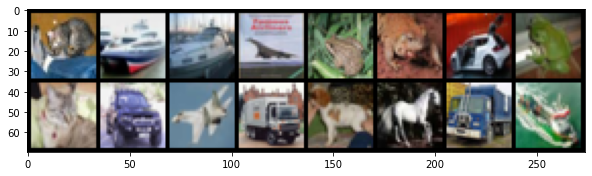

In [39]:
net.eval()
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
imgs = torchvision.utils.make_grid(images)
imgs = imgs.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Если взять первые 8 картинок, то в условие 5 из 8 получилось =)

In [40]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog' 'cat' 'car'
 'plane' 'truck' 'dog' 'horse' 'truck' 'ship']
['cat' 'truck' 'ship' 'plane' 'deer' 'frog' 'cat' 'frog' 'dog' 'car'
 'ship' 'truck' 'frog' 'horse' 'car' 'ship']
Accuracy is 0.5625
